**Getting our test set, transforming our categorical variables to numerical values and evaluating our first model**

In [1]:
import pandas as pd
import matplotlib as plt

In [2]:
df = pd.read_csv("project-3-files/learn_dataset.csv")
df

,Id,insee_code,is_student,OCCUPATION_42,ACTIVITY_TYPE,AGE_2019,household,Highest_degree,sex,target
0,1,01001,True,csp_6_8,TYPE1|1,20,TYPMR1-1,edu.1.4,Male,B
1,2,01004,False,csp_6_5,TYPE1|1,48,TYPMR4-1,edu.1.3,Male,B
2,3,01004,False,csp_8_1,TYPE1|2,37,TYPMR4-4,edu.1.8,Female,G
3,4,01004,False,csp_4_7,TYPE1|2,65,TYPMR3-1,edu.1.6,Male,B
4,5,01004,True,csp_8_4,TYPE2|2,22,TYPMR1-2,edu.1.4,Female,B
...,...,...,...,...,...,...,...,...,...,...
49988,99979,95680,False,csp_4_6,TYPE1|1,57,TYPMR1-2,edu.1.3,Female,B
49989,99981,95680,False,csp_8_5,TYPE2|5,25,TYPMR4-1,edu.1.4,Male,G
49990,99983,95680,True,csp_8_4,TYPE2|2,19,TYPMR4-2,edu.1.4,Female,B
49991,99984,95680,False,csp_4_7,TYPE1|1,48,TYPMR4-1,edu.1.7,Male,G


In [3]:
from sklearn.model_selection import train_test_split
import sklearn
sklearn.set_config(display="diagram")

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

**Our mission now is to understand whether our test set is correctly stratified**

**Unfortunately, we don't know for now which feature is the most explanatory for our target (label) variable. Therefore, we'll have to leave this on the side and come back to it later. I'm not even sure this is something we can do, since categories are spread out...**

In [4]:
X = train_set.drop(["target", "Id"], axis="columns")
y = train_set['target'].copy()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

Most ML algorithms prefer to work with numbers, so let's convert these categories from text to numbers.

In [6]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

Okay so here I'll have to check the type of data we have, if it is ordinal, nominal, etc. To see whether this is the case, I have to check all the data. I'll do this in another jupyter notebook.

In [7]:
preprocessing = make_column_transformer (
    (OneHotEncoder(), ["is_student", "OCCUPATION_42", "ACTIVITY_TYPE", "household", "sex"]),
    (OrdinalEncoder(), ["Highest_degree"]), #maybe I should check if it is well encoded 
    (ce.BinaryEncoder(), ["insee_code"]),
    remainder='passthrough')
logreg = LogisticRegression(solver='lbfgs', max_iter=2000)

In [8]:
pipe = make_pipeline(preprocessing, logreg)
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['is_student',
                                                   'OCCUPATION_42',
                                                   'ACTIVITY_TYPE', 'household',
                                                   'sex']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Highest_degree']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['insee_code'])])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [9]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['is_student',
                                                   'OCCUPATION_42',
                                                   'ACTIVITY_TYPE', 'household',
                                                   'sex']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['Highest_degree']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['insee_code'])])),
                ('logisticregression', LogisticRegression(max_iter=2000))])

In [10]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy").mean()

0.7535988569387391

In [11]:
y.value_counts(normalize=True) #null accuracy is what we get if we simply predict the most frequent class (here B).

B    0.615017
G    0.384983
Name: target, dtype: float64

In [12]:
# If we want to test this model on new data, here is the code
# pipe.fit(X, y)
# pipe.predict(X_new)

In [13]:
y_pred = pipe.predict(X_train)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Paramètres pour GridSearchCV
param_grid = {
    'logisticregression__C': [40, 100, 200],  # Coefficients de régularisation
    'logisticregression__penalty': ['l2']  # Normes de régularisation
}

# Initialisation de GridSearchCV
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')

# Entraînement avec GridSearchCV
grid_search.fit(X_train, y_train)

# Meilleurs paramètres et meilleur score
print("Meilleurs paramètres: ", grid_search.best_params_)
print("Meilleur score de cross-validation: ", grid_search.best_score_)

# Utiliser le meilleur modèle pour prédire les données de test
y_pred = grid_search.predict(X_test)

# Calculer des métriques de performance
print("Précision: ", accuracy_score(y_test, y_pred))
print("Rappel: ", recall_score(y_test, y_pred, pos_label='B'))
print("Score F1: ", f1_score(y_test, y_pred, pos_label='B'))

# Générer des graphiques
# ...



Meilleurs paramètres:  {'logisticregression__C': 100, 'logisticregression__penalty': 'l2'}
Meilleur score de cross-validation:  0.7537774602607609
Précision:  0.7606467205600467
Rappel:  0.8643631436314363
Score F1:  0.8162507997440819


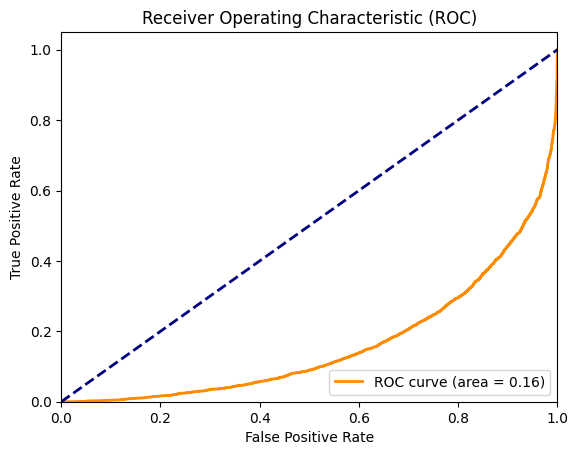

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Prédire les probabilités pour la classe positive
y_scores = grid_search.predict_proba(X_test)[:, 1]

# Calculer les taux de faux et vrais positifs
fpr, tpr, thresholds = roc_curve(y_test, y_scores, pos_label='B')

# Calculer l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()